## Загрузить новости из любой ленты и найти среднюю частоту ее обновления

В качестве примера возьмем ленту обновления колод сайта Tempostorm.

Откроем https://tempostorm.com/hearthstone/decks и посмотрим на XHR вызовы которые эта страница делает к backend. Сразу же в глаза бросается 2 вызова к https://tempostorm.com/api/decks с параметром выглядешим как JSON. Давайте посмотрим так ли это.



Объявляем необхожимые библиотеки и создаем PrettyPrinter - удобный инструмент когда нужно смотреть на комплексные данные.

In [52]:
# coding=utf-8
%matplotlib inline
import json
import pprint
import requests
import warnings
import pandas as pd
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')  # To skip annoying requests warnings
pp = pprint.PrettyPrinter()

In [53]:
request = json.loads('{"where":{"isFeatured":true},"fields":{"id":true,"name":true,"heroName":true,"authorId":true,"playerClass":true,"createdDate":true,"premium":true},"include":[{"relation":"author","scope":{"fields":["id","username"]}},{"relation":"votes","scope":{"fields":["direction"]}},{"relation":"slugs"}],"order":"createdDate+DESC","skip":0,"limit":4}')
pp.pprint(request)

{u'fields': {u'authorId': True,
             u'createdDate': True,
             u'heroName': True,
             u'id': True,
             u'name': True,
             u'playerClass': True,
             u'premium': True},
 u'include': [{u'relation': u'author',
               u'scope': {u'fields': [u'id', u'username']}},
              {u'relation': u'votes', u'scope': {u'fields': [u'direction']}},
              {u'relation': u'slugs'}],
 u'limit': 4,
 u'order': u'createdDate+DESC',
 u'skip': 0,
 u'where': {u'isFeatured': True}}


Итак, это действительно полноценный запрос, включая сортировку и включение реляционных отношений. На будущее нам могут понадобиться списки карт из этих колод, потому давайте перейдем по одной из ссылок (https://tempostorm.com/hearthstone/decks/malygos-shaman-wild-meta-snapshot-jan-22-2017) и посмотрим какие данные загружаются там.

Видно вызов к https://tempostorm.com/api/findOne с очень похожим параметром. Рассмотрим подробнее и его. 

In [54]:
request2= json.loads('{"where":{"slug":"malygos-shaman-wild-meta-snapshot-jan-22-2017"},"fields":["id","createdDate","name","description","playerClass","premium","dust","heroName","authorId","deckType","isPublic","chapters","youtubeId","gameModeType","isActive","isCommentable"],"include":[{"relation":"cards","scope":{"include":"card","scope":{"fields":["id","name","cardType","cost","dust","photoNames"]}}},{"relation":"comments","scope":{"fields":["id","votes","authorId","createdDate","text"],"include":{"relation":"author","scope":{"fields":["id","username","gravatarUrl"]}}}},{"relation":"author","scope":{"fields":["id","username"]}},{"relation":"matchups","scope":{"fields":["forChance","deckName","className"]}},{"relation":"votes","fields":["id","direction","authorId"]}]}')
pp.pprint(request2)

{u'fields': [u'id',
             u'createdDate',
             u'name',
             u'description',
             u'playerClass',
             u'premium',
             u'dust',
             u'heroName',
             u'authorId',
             u'deckType',
             u'isPublic',
             u'chapters',
             u'youtubeId',
             u'gameModeType',
             u'isActive',
             u'isCommentable'],
 u'include': [{u'relation': u'cards',
               u'scope': {u'include': u'card',
                          u'scope': {u'fields': [u'id',
                                                 u'name',
                                                 u'cardType',
                                                 u'cost',
                                                 u'dust',
                                                 u'photoNames']}}},
              {u'relation': u'comments',
               u'scope': {u'fields': [u'id',
                                      u'votes',


Заметим, что поисковый запрос (slug) в данном случае совпадает с последней частью URL (malygos-shaman-wild-meta-snapshot-jan-22-2017), таким образом наверняка именно это является уникальным поисковым индексом в хранилище. Однако если посмотреть вывод результатов этого запроса - видно что поля id имеют характерный ObjectId вид (к примеру 5883f76d914710ea2030fae2) из чего мы можем сделать вывод о том, что информация в этом сайте хранится в Mongo. 

В обычной ситуации, если мы хотим сгрузить данные о колодах, нам бы пришлось делать один запрос на список колод и дальше подзапросы на каждую колоду. Но сайт любезно предоставляет нам свободный формат запроса, так может попробовать...

In [55]:
request['include'] = [{u'relation': u'cards', u'scope': {u'include': u'card'}}]
resp = requests.get('https://tempostorm.com/api/decks?filter=' + json.dumps(request))
data = resp.json()
pp.pprint(data[0])

{u'authorId': u'548d164297aa6c096ccb734a',
 u'cards': [{u'card': {u'artist': u'Michael Sutfin',
                       u'attack': 0,
                       u'cardType': u'Spell',
                       u'cost': 0,
                       u'deckable': True,
                       u'durability': 0,
                       u'dust': 0,
                       u'expansion': u'Basic',
                       u'flavor': u'It\'s funny how often yelling "Look over there!" gets your opponent to turn around.',
                       u'health': 0,
                       u'hearthstoneId': u'CS2_072',
                       u'id': u'5411e7f19d2333d418373e0b',
                       u'isActive': True,
                       u'isTriClass': False,
                       u'mechanics': [],
                       u'name': u'Backstab',
                       u'photoNames': {u'large': u'backstab.large.png',
                                       u'medium': u'backstab.medium.png',
                               

Ура! Значит мы сможем выгружать данные о колодах прямо в запросе списка! 
Запомним эту информацию на будущее, но пока для текущего задания нам нужна только информация о частоте появления новых колод. Поэтому составим свой "синтетический" запрос (на сайте такие нигде не используются) и получим требуемые данные.

In [56]:
request = {u'fields': {u'createdDate': True,
                       u'playerClass': True},
           u'limit': 1000000,  # random stupidly big number
           u'order': u'createdDate+ASC',
           u'skip': 0,
           u'where': {u'isFeatured': False}}
resp = requests.get('https://tempostorm.com/api/decks?filter=' + json.dumps(request))
data = resp.json()
print len(data)

100


Ага... на сайте около 13 тысяч колод, но нам вернуло только 100. Похоже, что одним запросом все же вытащить не получится - кто-то из разработчиков установил жесткий лимит на количество возвращаемых данных (что, в целом, ОЧЕНЬ хорошая идея если вы допускаете свободный формат запроса данных...)

In [57]:
total_data = []
skip = 0
while True:
    print skip
    request = {u'fields': {u'createdDate': True, 'name': True, u'playerClass': True},
               u'limit': 100,
               u'order': u'createdDate+ASC',
               u'skip': skip,
               u'where': {u'isFeatured': False}}

    resp = requests.get('https://tempostorm.com/api/decks?filter=' + json.dumps(request))
    data = resp.json()
    if len(data) == 0:
        break
    print data[0]['name']
    total_data += data
    skip += 100
    
df = pd.DataFrame(total_data)
df.head()

0
Windfury Shaman by Reynad
100
Weapon Rogue.
200
Weapon Rogue 2
300
pong hunter
400
Calling all Ancestors
500
ALA's Handlock
600
A Begginners Deck by Benjitso
700
TRUE CANCER
800
Reynad Mech Druid from Stream 1/29/2015
900
NOskillALLface
1000
Mage arena
1100
retardado
1200
[Myth] Forest Giants
1300
F2P Rogue Tempo
1400
XSSPOC
1500
GOOBYSENCHOU Shaman
1600
Violet Rogue
1700
Perfeckt Rush Priest, Boooom!!
1800
Midrange Hunter legend #338 N/A
1900
Slothslayer's Mech Rouge
2000
Bolvar Fordragon Fights Back!
2100
Neverending control
2200
Sylvanas reincarnate
2300
Anti-Thaurissan Heroic Paladin
2400
Aggro Patron Power!
2500
Legend Control
2600
tato
2700
Demonolgy
2800
Mage midrange blackrockmountain
2900
Reynad Tempo Rogue (Ren)
3000
Overload Midrange Shaman
3100
Krieger
3200
Shaman Deck
3300
Very low budget mechish midrange/aggro
3400
did i get it right? Kappa
3500
BRM - Imp Gang Orgy
3600
Hyude Dragon Warrior
3700
theory  shaman
3800
Uncle face
3900
LOKShadow Dragon Warrior
4000
Demon Zoo

,createdDate,name,playerClass
0,2014-12-11T20:01:17.997Z,Windfury Shaman by Reynad,Shaman
1,2014-12-11T20:13:16.995Z,BMA's Chowlock Deck,Warlock
2,2014-12-12T03:56:04.037Z,[GvG] Mecha Zoo By Gaara,Warlock
3,2014-12-12T22:57:19.684Z,Tempo Mage,Mage
4,2014-12-12T23:50:56.608Z,Kitkatz's Control Warrior,Warrior


In [58]:
df.dtypes

createdDate    object
name           object
playerClass    object
dtype: object

Как видим колонка createdDate не смотря на то, что представляет собой ISO формат даты не была распознана как таковая. Давайте намекнём pandas.

In [59]:
df['date'] = pd.to_datetime(df['createdDate'])
df.head()

,createdDate,name,playerClass,date
0,2014-12-11T20:01:17.997Z,Windfury Shaman by Reynad,Shaman,2014-12-11 20:01:17.997
1,2014-12-11T20:13:16.995Z,BMA's Chowlock Deck,Warlock,2014-12-11 20:13:16.995
2,2014-12-12T03:56:04.037Z,[GvG] Mecha Zoo By Gaara,Warlock,2014-12-12 03:56:04.037
3,2014-12-12T22:57:19.684Z,Tempo Mage,Mage,2014-12-12 22:57:19.684
4,2014-12-12T23:50:56.608Z,Kitkatz's Control Warrior,Warrior,2014-12-12 23:50:56.608


In [60]:
df.dtypes

createdDate            object
name                   object
playerClass            object
date           datetime64[ns]
dtype: object

In [61]:
# Copy index to separate column just for usability
df['index']=df.index

Посмотрим на наши данные

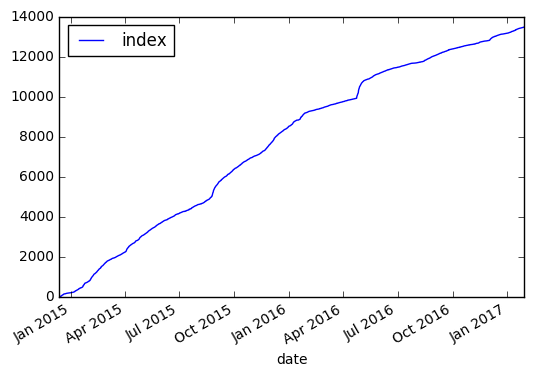

In [62]:
df.set_index(['date'],inplace=True)
df.plot()

Любопытно, что случилось весной 2016? 
А я могу сказать, что случилось - именно тогда сайт менял то ли вообще движок, то ли особенности реализации backend, но у него тогда был период нестабильности. И судя по тому, что скорость обновления после этого так и не восстановилась полностью - часть посетителей за этот период они потеряли, те ушли на другие аналогичные ресурсы.

Ладно, возвращаем индекс на место.

In [63]:
df.reset_index(inplace=True)

Вычисляем средний промежуток между обновлениями. Для этого возьмем данные с первой и последней строки (если посмотреть на запрос - мы сортировали как раз по дате, так что они будут соответствовать первой и последней добавленной колоде) и разделим на количество промежутков между обновлениями (то есть количество записей о колодах - 1)

In [64]:
firstdate = df.head(1).iloc[0]['date']
lastdate = df.tail(1).iloc[0]['date']
timedelta_between_updates = (lastdate-firstdate)/(df.shape[0] - 1)
timedelta_between_updates.value

4995369257416

обратите внимение, что value в объектах времени pandas - это данные в НАНОсекундах.  

In [65]:
timedelta_between_updates_in_seconds = timedelta_between_updates.value/float(10**9)
timedelta_between_updates_in_seconds

4995.369257416

Нас спрашивали ЧАСТОТУ обновлений, то есть величину, обратную промежутку между обновлениями. Её и выводим. После чего сохраним данные на будущее.

In [66]:
frequency=1/timedelta_between_updates_in_seconds
frequency

0.00020018540141260327

In [67]:
df.to_csv('tempostorm_date.csv', encoding='utf-8')